In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import sys
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,RidgeCV
from sklearn.model_selection import KFold
from dca.cov_util import form_lag_matrix, calc_cross_cov_mats_from_data
import glob
import pdb
from statsmodels.tsa import stattools
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sys.path.append('/home/akumar/nse/neural_control')
from loaders import load_sabes, reach_segment_sabes
from decoders import lr_decoder
from utils import apply_df_filters

#### Consolidate 25 ms fits

In [24]:
# Consolidate 25 ms fits
fls = glob.glob('/mnt/Secondary/data/mpi_cc25/*.pkl')
rl = []
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                result = pickle.load(f)
                rl.append(result)
            except (EOFError):
                break
df = pd.DataFrame(rl)
# Filter out erroneous data_file
df = apply_df_filters(df, fl=['/mnt/Secondary/data/sabes_tmp25/indy_20160426_01.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170210_03.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170213_02.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170214_02.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170215_02.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170216_02.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170217_02.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170227_04.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170228_02.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170301_05.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170302_02.pkl'])

In [ ]:
# Get the canonical correlation coefficients.
cc_coefs = np.zeros((df.shape[0], 6))
r2_scores = np.zeros(df.shape[0])
# These are the 

for i in range(df.shape[0]):
    print(i)
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    lag = df.iloc[i]['lag']
    w = df.iloc[i]['win']


    # Apply window and lag relative to each other
    if lag != 0:
        x = X[:-lag, :]
        y = Y[lag:, :]
    else:
        x = X
        y = Y

    if w > 1:
        x = form_lag_matrix(x, w)
        y = form_lag_matrix(y, w)


    model = df.iloc[i]['ccamodel']
    X_c, Y_c = model.transform(x, y)
    ccc2 = np.array([scipy.stats.pearsonr(X_c[:, j], Y_c[:, j])[0] for j in range(X_c.shape[1])])    
    cc_coefs[i, :] = ccc2
    r2_scores[i] = model.score(x, y)

In [ ]:
df['cc_coefs'] = list(cc_coefs)
df['r2_scores'] = list(r2_scores)

In [ ]:
with open('/mnt/Secondary/data/postprocessed/cca_timescales_df25.pkl', 'wb') as f:
    f.write(pickle.dumps(df))

#### Consolidating 50 ms fits on folds of the data

In [50]:
# Increased dimensionality to 12
fls = glob.glob('/mnt/Secondary/data/mpi_cc50cv/*.pkl')
rl = []
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                result = pickle.load(f)
                rl.append(result)
            except (EOFError):
                break
df = pd.DataFrame(rl)
# Filter out erroneous data_file

In [52]:
# Get the canonical correlation coefficients.
cc_coefs = np.zeros((df.shape[0], 12))
r2_scores = np.zeros(df.shape[0])

for i in range(df.shape[0]):
    print(i)
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    fold_idx = df.iloc[i]['fold_idx']
    train_idxs, test_idxs = list(KFold(n_splits=5).split(X))[fold_idx]
    x = X[train_idxs]
    y = Y[train_idxs]

    lag = df.iloc[i]['lag']
    w = df.iloc[i]['win']

    # Apply window and lag relative to each other
    if lag != 0:
        x = x[:-lag, :]
        y = Y[lag:, :]

    if w > 1:
        x = form_lag_matrix(x, w)
        y = form_lag_matrix(y, w)

    model = df.iloc[i]['ccamodel']
    X_c, Y_c = model.transform(x, y)
    ccc2 = np.array([scipy.stats.pearsonr(X_c[:, j], Y_c[:, j])[0] for j in range(X_c.shape[1])])    
    cc_coefs[i, :] = ccc2
    r2_scores[i] = model.score(x, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [53]:
df['cc_coefs'] = list(cc_coefs)
df['r2_scores'] = list(r2_scores)

In [54]:
with open('/mnt/Secondary/data/postprocessed/sabes_cca50cv_df.dat', 'wb') as f:
    f.write(pickle.dumps(df))

### Time-resolved decoding for 50 ms bins

In [4]:
fls = glob.glob('/home/akumar/nse/neural_control/data/s1m1regvt/*.dat')

In [5]:
data_file = '/mnt/Secondary/data/sabes/indy_20160426_01.mat'
dat = load_sabes(data_file)
dat = reach_segment_sabes(dat, data_file=data_file.split('/')[-1].split('.mat')[0])

fls = glob.glob('/home/akumar/nse/neural_control/data/s1m1regvt/*.dat')
rl = []

for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    # dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[3:]

    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-2]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        window_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['error_filter'] = error_filter
    result['window_filter'] = window_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['dim'] = 6
    result['measure_from_end'] = measure_from_end

    for k, v in filter_params.items():
        result[k] = v
    
    rl.append(result)
dvt_df = pd.DataFrame(rl)

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [7]:
np.array(dvt_df.iloc[0]['r2']).shape

(20, 5, 10)

In [28]:
r2p.shape

(224,)

In [ ]:
# Time-resolved decoding of FCCA/PCA subspaces

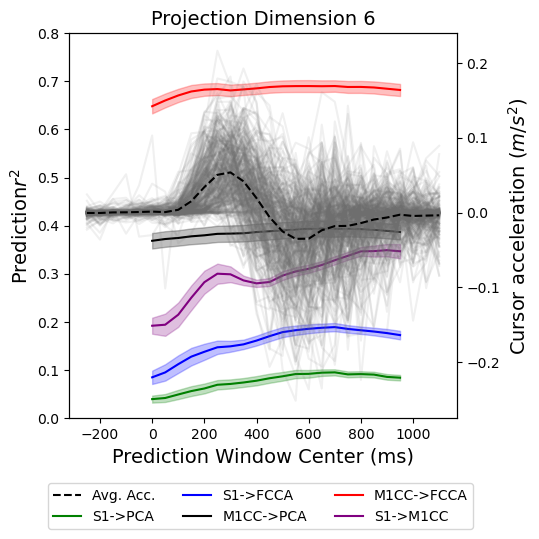

In [40]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

#windows = dvt_df.iloc[0]['window']
#window_centers = np.linspace(0, 35, 15)[0:9]

# Dense windows
window_centers = np.arange(20)
df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=6)
a = ax.twinx()

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=7)
error_filter = d.iloc[0]['error_filter']
reach_filter = d.iloc[0]['reach_filter']
window_filter = d.iloc[0]['window_filter']

# Intersection
transition_times = np.array(dat['transition_times'])[error_filter][reach_filter][window_filter]

vel_all = []
acc_all = []
for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 25], axis=0), axis=1)/(1e3 * 0.05)
    acc = np.diff(vel)
    acc_all.append(acc)
    vel_all.append(vel)
    a.plot(50 * np.arange(-5, 23), acc, color='#6e6e6e', alpha=0.1, zorder=-100)
    a.set_ylabel('Cursor acceleration ' r'$(m/s^2)$', fontsize=14)

vel_all = np.array(vel_all)
vel_all = np.mean(vel_all, axis=0)
acc_all = np.array(acc_all)
acc_all = np.mean(acc_all, axis=0)

a.plot(50 * np.arange(-5, 23), acc_all, linestyle='--', color='k')
# Dummy for legend
ax.plot(np.nan, linestyle='--', color='k', label='Avg. Acc.') 

r2_S1toPCA = []
r2_S1toFCA = []
r2_M1CtoPCA = []
r2_M1CtoFCA = []
r2_S1toM1C = []

for j in range(df_.shape[0]):
    r2_S1toPCA.append(np.nanmean(df_.iloc[j]['r2'][:, :, 1], axis=1))
    r2_S1toFCA.append(np.nanmean(df_.iloc[j]['r2'][:, :, 3], axis=1))
    r2_M1CtoPCA.append(np.nanmean(df_.iloc[j]['r2'][:, :, 5], axis=1))
    r2_M1CtoFCA.append(np.nanmean(df_.iloc[j]['r2'][:, :, 7], axis=1))
    r2_S1toM1C.append(np.nanmean(df_.iloc[j]['r2'][:, :, 9], axis=1))

r2_S1toPCA = np.array(r2_S1toPCA).T
r2_S1toFCA = np.array(r2_S1toFCA).T
r2_M1CtoPCA = np.array(r2_M1CtoPCA).T
r2_M1CtoFCA = np.array(r2_M1CtoFCA).T
r2_S1toM1C = np.array(r2_S1toM1C).T

def plot_trace(r2, col, label):
    ax.fill_between(50 * window_centers, np.array([np.mean(r) for r in r2]) - np.array([np.std(r)/np.sqrt(28) for r in r2]), 
                    np.array([np.mean(r) for r in r2]) + np.array([np.std(r)/np.sqrt(28) for r in r2]),
                    color=col, alpha=0.25, zorder=100)
    ax.plot(50 * window_centers, [np.mean(r) for r in r2], '-', color=col, label=label)

plot_trace(r2_S1toPCA, 'g', 'S1->PCA')
plot_trace(r2_S1toFCA, 'b', 'S1->FCCA')
plot_trace(r2_M1CtoPCA, 'k', 'M1CC->PCA')
plot_trace(r2_M1CtoFCA, 'r', 'M1CC->FCCA')
plot_trace(r2_S1toM1C, 'purple', 'S1->M1CC')

ax.set_ylim([0, 0.8])
ax.set_ylabel('Prediction' + r'$r^2$', fontsize=14)
ax.set_xlabel('Prediction Window Center (ms)', fontsize=14)
ax.set_title('Projection Dimension 6', fontsize=14)
ax.legend(bbox_to_anchor=(1.06, -0.15), fontsize=10, ncol=3)

# fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cca/decoding_vs_t.pdf', bbox_inches='tight', pad_inches=0)

In [12]:
# Second plot: Just a visualization of the FCCA/PCA delta with the timing difference highlighted
# Cross-validated using the dimreduc fit on each fold
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    rl = pickle.load(f)
sabes_df = pd.DataFrame(rl)

data_idx = 0

fls = glob.glob('/home/akumar/nse/neural_control/data/decodingvt_cv_dense2/*.dat')
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    # dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[5:]
    
    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-2]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        window_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['error_filter'] = error_filter
    result['window_filter'] = window_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['dim'] = 6
    result['measure_from_end'] = measure_from_end

    for k, v in filter_params.items():
        result[k] = v
    
    rl.append(result)
dvt_df2 = pd.DataFrame(rl)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [30]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

#windows = dvt_df.iloc[0]['window']
#window_centers = np.linspace(0, 35, 15)[0:9]

# Dense windows
window_centers = np.arange(20)
df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=6)
df2_ = apply_df_filters(dvt_df2, error_thres=1, error_op='le',filter_type=0, q=0, op='le', dim=6)
a = ax.twinx()

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=7)
error_filter = d.iloc[0]['error_filter']
reach_filter = d.iloc[0]['reach_filter']
window_filter = d.iloc[0]['window_filter']

# Intersection
transition_times = np.array(dat['transition_times'])[error_filter][reach_filter][window_filter]

vel_all = []
acc_all = []
for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 25], axis=0), axis=1)/(1e3 * 0.05)
    acc = np.diff(vel)
    vel_all.append(vel)
    acc_all.append(acc)
    a.plot(50 * np.arange(-5, 24), vel, color='#6e6e6e', alpha=0.1, zorder=0)
    a.set_ylabel('Cursor velocity (m/s)', fontsize=14)

vel_all = np.array(vel_all)
vel_all = np.mean(vel_all, axis=0)
acc_all = np.mean(acc_all, axis=0)
a.plot(50 * np.arange(-5, 24), vel_all, linestyle='--', color='k')
a.plot(50 * np.arange(-5, 23), acc_all, linestyle='--', color='b')

# Dummy for legend
ax.plot(np.nan, linestyle='--', color='k', label='Avg. Vel.') 
ax.plot(np.nan, linestyle='--', color='b', label='Avg. Acc.') 

r2_S1toM1C = []
r2p = []
r2f = []

for j in range(df_.shape[0]):
    r2_S1toM1C.append(np.nanmean(df_.iloc[j]['r2'][:, :, 9], axis=1))

r2_S1toM1C = np.array(r2_S1toM1C).T

for j in range(df2_.shape[0]):
    

def plot_trace(r2, col, label):
    ax.fill_between(50 * window_centers, np.array([np.mean(r) for r in r2]) - np.array([np.std(r)/np.sqrt(28) for r in r2]), 
                    np.array([np.mean(r) for r in r2]) + np.array([np.std(r)/np.sqrt(28) for r in r2]),
                    color=col, zorder=0, alpha=0.25)
    ax.plot(50 * window_centers, [np.mean(r) for r in r2], '-', color=col, zorder=0, label=label)

plot_trace(r2_S1toPCA, 'g', 'S1->PCA')
plot_trace(r2_S1toFCA, 'b', 'S1->FCCA')
plot_trace(r2_M1CtoPCA, 'k', 'M1CC->PCA')
plot_trace(r2_M1CtoFCA, 'r', 'M1CC->FCCA')
plot_trace(r2_S1toM1C, 'purple', 'S1->M1CC')

ax.set_ylim([0, 1.0])
ax.set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
ax.set_xlabel('Decoding Window Center (ms)', fontsize=14)
ax.set_title('Projection Dimension 6', fontsize=14)
ax.legend(loc='upper left')

fig.tight_layout()
# fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/final.pdf', bbox_inches='tight', pad_inches=0)

IndentationError: expected an indented block (3730172123.py, line 54)

### Final (non-time resolved) figures

In [5]:
with open('/mnt/Secondary/data/postprocessed/sabes_cca50cv_df.dat', 'rb') as f:
    ccadf = pickle.load(f)

In [6]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    indy_df = pickle.load(f)
indy_df = pd.DataFrame(indy_df)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
fls = np.unique(ccadf['fl'].values)

8it [00:00, 1707.17it/s]


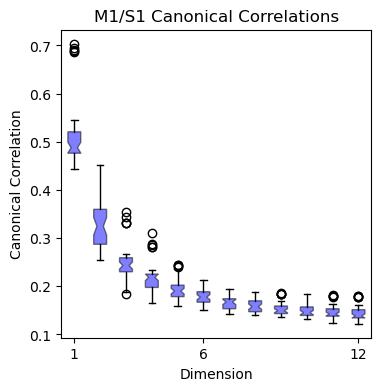

In [8]:
# Canonical correlation coefficients
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

cc_coefs = np.zeros((8, 5, 12))
for i, fl in tqdm(enumerate(fls)):
    dc_ = apply_df_filters(ccadf, fl=fl)
    for j in range(dc_.shape[0]):
        cc_coefs[i, j, :] = dc_.iloc[j]['cc_coefs']

medianprops = dict(linewidth=0)
bplot = ax.boxplot(np.reshape(cc_coefs, (-1, 12)), patch_artist=True, medianprops=medianprops, notch=True)

for patch in bplot['boxes']:
    patch.set_facecolor('b')
    patch.set_alpha(0.5)

ax.set_title('M1/S1 Canonical Correlations')
ax.set_ylabel('Canonical Correlation')
ax.set_xlabel('Dimension')
ax.set_xticks([1, 6, 12])
ax.set_xticklabels([1, 6, 12])

fig.savefig('/home/akumar/nse/neural_control/figs/cca/cc_coef.pdf', bbox_inches='tight', pad_inches=0)

In [9]:
# CC to SS regression
cc2ssr2 = np.zeros((fls.size, 2, 5))
dim = 6
lag = 0
w = 3
for i, fl in tqdm(enumerate(fls)):
    with open(fl, 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)

    y = datM1['spike_rates'].squeeze()
    x = datS1['spike_rates'].squeeze()


    # Get the subspaces
    data_file = fl.split('/')[-1].split('.pkl')[0]
    data_file += '.mat'

    if 'indy' in data_file:
        pcadf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='PCA', dim=dim)
    elif 'loco' in data_file:
        pcadf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='PCA', dim=dim)

    assert(pcadf.shape[0] == 5)

    # For each fold, and dimensions 2-6, measure the min and average subspace angle
    for fold in range(5):
        d_ = apply_df_filters(pcadf, fold_idx=fold)
        dc_ = apply_df_filters(ccadf, fold_idx=fold, fl=fl)
        model = dc_.iloc[0]['ccamodel']

        Vpca = d_.iloc[0]['coef']

        # M1 PCA
        ytrain = y[d_.iloc[0]['train_idxs']] @ Vpca
        ytest = y[d_.iloc[0]['test_idxs']] @ Vpca        

        # M1 CCA
        xtrain = y[d_.iloc[0]['train_idxs']] @ model.y_weights_[:, 0:6]
        xtest = y[d_.iloc[0]['test_idxs']] @ model.y_weights_[:, 0:6]

        # Window
        if w > 1:
            xtrain = form_lag_matrix(xtrain, w)
            xtest = form_lag_matrix(xtest, w)
            ytrain = ytrain[w//2:]
            ytrain = ytrain[:xtrain.shape[0]]
            ytest = ytest[w//2:]
            ytest = ytest[:xtest.shape[0]]

        ytrain = StandardScaler().fit_transform(ytrain)
        xtrain = StandardScaler().fit_transform(xtrain)

        ytest = StandardScaler().fit_transform(ytest)
        xtest = StandardScaler().fit_transform(xtest)

        linmodel = RidgeCV()
        linmodel.fit(xtrain, ytrain)
        cc2ssr2[i, 0, fold] = linmodel.score(xtest, ytest)

    if 'indy' in data_file:
        lqgdf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='LQGCA', dim=6, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})
    elif 'loco' in data_file:
        lqgdf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='LQGCA', dim=6, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})

    assert(lqgdf.shape[0] == 5)

    for fold in range(5):
        d_ = apply_df_filters(lqgdf, fold_idx=fold)
        dc_ = apply_df_filters(ccadf, fold_idx=fold, fl=fl)
        model = dc_.iloc[0]['ccamodel']

        Vlqg = d_.iloc[0]['coef']

        # M1 LGQ
        ytrain = y[d_.iloc[0]['train_idxs']] @ Vlqg
        ytest = y[d_.iloc[0]['test_idxs']] @ Vlqg      

        # M1 CCA
        xtrain = y[d_.iloc[0]['train_idxs']] @ model.y_weights_[:, 0:6]
        xtest = y[d_.iloc[0]['test_idxs']] @ model.y_weights_[:, 0:6]

        # Window
        if w > 1:
            xtrain = form_lag_matrix(xtrain, w)
            xtest = form_lag_matrix(xtest, w)
            ytrain = ytrain[w//2:]
            ytrain = ytrain[:xtrain.shape[0]]
            ytest = ytest[w//2:]
            ytest = ytest[:xtest.shape[0]]


        ytrain = StandardScaler().fit_transform(ytrain)
        xtrain = StandardScaler().fit_transform(xtrain)

        ytest = StandardScaler().fit_transform(ytest)
        xtest = StandardScaler().fit_transform(xtest)

        linmodel = RidgeCV()
        linmodel.fit(xtrain, ytrain)
        cc2ssr2[i, 1, fold] = linmodel.score(xtest, ytest)


8it [00:04,  1.63it/s]


In [10]:
stat, p = scipy.stats.wilcoxon(cc2ssr2[:, 1, :].ravel(), cc2ssr2[:, 0, :].ravel())


In [11]:
p

1.8189894035458565e-12

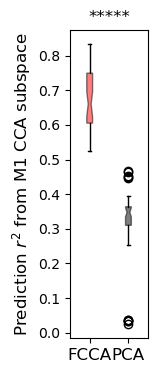

In [12]:
fig, ax = plt.subplots(figsize=(1, 4))
medianprops = dict(linewidth=0)
bplot = ax.boxplot([cc2ssr2[:, 1, :].ravel(), cc2ssr2[:, 0, :].ravel()], patch_artist=True, medianprops=medianprops, notch=True)

bplot['boxes'][0].set_facecolor('r')
bplot['boxes'][1].set_facecolor('k')

for patch in bplot['boxes']:
    patch.set_alpha(0.5)
ax.set_title('*****')
ax.set_xticklabels(['FCCA', 'PCA'], fontsize=12)
ax.set_ylabel('Prediction ' + r'$r^2$' + ' from M1 CCA subspace', fontsize=12)
fig.savefig('/home/akumar/nse/neural_control/figs/cca/m1cc2ss.pdf', bbox_inches='tight', pad_inches=0)

In [34]:
ccadf.shape

(40, 11)

In [13]:
from utils import calc_loadings

In [14]:
# Leverage scores and subspace angles
dim = 6

cca_loadings = []
pca_loadings = []
fcca_loadings = []
for i, fl in tqdm(enumerate(fls)):
    ccalf = []
    pcalf = []
    fcclf = []
    for fold in range(5):
        dfc_ = apply_df_filters(ccadf, fl=fl, fold_idx=fold)
        data_file = fl.split('/')[-1].split('.pkl')[0]
        data_file += '.mat'

        if 'indy' in data_file:
            pcadf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='PCA', dim=dim, fold_idx=fold)
        elif 'loco' in data_file:
            pcadf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='PCA', dim=dim, fold_idx=fold)

        if 'indy' in data_file:
            lqgdf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='LQGCA', dim=6, fold_idx=fold)
        elif 'loco' in data_file:
            lqgdf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='LQGCA', dim=6, fold_idx=fold)

        assert(dfc_.shape[0] == 1)
        assert(pcadf.shape[0] == 1)
        assert(lqgdf.shape[0] == 1)

        model = dfc_.iloc[0]['ccamodel']
        ccalf.append(calc_loadings(model.y_weights_[:, 0:dim]))
        pcalf.append(calc_loadings(pcadf.iloc[0]['coef'][:, 0:dim]))
        fcclf.append(calc_loadings(lqgdf.iloc[0]['coef'][:, 0:dim]))

    ccalf = np.mean(np.array(ccalf), axis=0)
    pcalf = np.mean(np.array(pcalf), axis=0)
    fcclf = np.mean(np.array(fcclf), axis=0)

    cca_loadings.extend(ccalf)
    pca_loadings.extend(pcalf)
    fcca_loadings.extend(fcclf)

8it [00:00, 70.93it/s]


In [15]:
# Leverage scores and subspace angles
dim = 6

cca_pca_ssa = []
cca_fcca_ssa = []
for i, fl in tqdm(enumerate(fls)):
    cca_pca_ssaf = []
    cca_fcca_ssaf = []
    for fold in range(5):
        dfc_ = apply_df_filters(ccadf, fl=fl, fold_idx=fold)
        data_file = fl.split('/')[-1].split('.pkl')[0]
        data_file += '.mat'

        if 'indy' in data_file:
            pcadf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='PCA', dim=dim, fold_idx=fold)
        elif 'loco' in data_file:
            pcadf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='PCA', dim=dim, fold_idx=fold)

        if 'indy' in data_file:
            lqgdf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, fold_idx=fold)
        elif 'loco' in data_file:
            lqgdf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, fold_idx=fold)

        assert(dfc_.shape[0] == 1)
        assert(pcadf.shape[0] == 1)
        assert(lqgdf.shape[0] == 1)
        model = dfc_.iloc[0]['ccamodel']
        cca_pca_ssaf.append(scipy.linalg.subspace_angles(model.y_weights_[:, 0:dim], pcadf.iloc[0]['coef'][:, 0:dim]))
        cca_fcca_ssaf.append(scipy.linalg.subspace_angles(model.y_weights_[:, 0:dim], lqgdf.iloc[0]['coef'][:, 0:dim]))

    cca_pca_ssaf = np.mean(np.array(cca_pca_ssaf), axis=0)
    cca_fcca_ssaf = np.mean(np.array(cca_fcca_ssaf), axis=0)

    cca_pca_ssa.extend(cca_pca_ssaf)
    cca_fcca_ssa.extend(cca_fcca_ssaf)

8it [00:00, 54.31it/s]


In [16]:
pcadf.iloc[0]['coef'].shap

AttributeError: 'numpy.ndarray' object has no attribute 'shap'

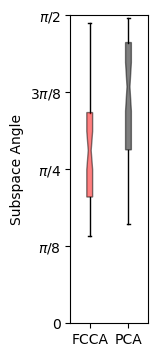

In [18]:
# Just the boxplots
fig, ax = plt.subplots(figsize=(1, 4))
bplot = ax.boxplot([cca_fcca_ssa, cca_pca_ssa], medianprops={'linewidth':0}, notch=True, patch_artist=True)

bplot['boxes'][0].set_facecolor('r')
bplot['boxes'][1].set_facecolor('k')

bplot['boxes'][0].set_alpha(0.5)
bplot['boxes'][1].set_alpha(0.5)

ax.set_xticklabels(['FCCA', 'PCA'])
ax.set_yticks([0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2])
ax.set_yticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
ax.set_ylim([0, np.pi/2])
ax.set_ylabel('Subspace Angle')

fig.savefig('/home/akumar/nse/neural_control/figs/cca/ss_angles_only.pdf', bbox_inches='tight', pad_inches=0)

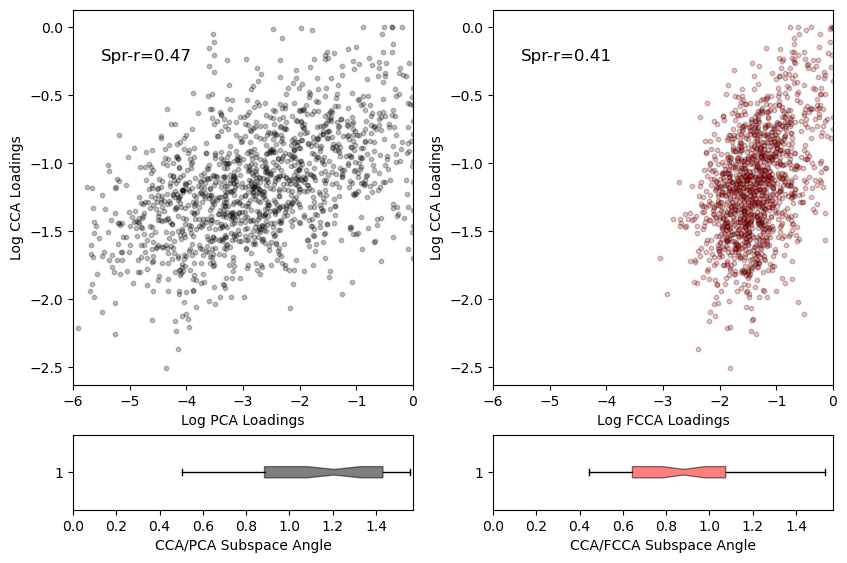

In [28]:
fig = plt.figure(figsize=(8, 5))

eps = 5e-2

rect1 = [0, 1./5. + eps, 0.425, 4./5 - eps]
rect2 = [0.525, 1./5. + eps, 0.425, 4./5. - eps]

rect3 = [0, 0, 0.425, 1./5. - eps]
rect4 = [0.525, 0, 0.425, 1./5. - eps]

ax00 = fig.add_axes(rect1)
ax01 = fig.add_axes(rect2)
ax10 = fig.add_axes(rect3)
ax11 = fig.add_axes(rect4)

ax00.scatter(np.log10(pca_loadings), np.log10(cca_loadings), color='k', alpha=0.25, s=10, edgecolors='k')
ax01.scatter(np.log10(fcca_loadings), np.log10(cca_loadings), color='r', alpha=0.25, s=10, edgecolors='k')
ax01.set_xlim([-6, 0])
ax00.set_xlim([-6, 0])
r1 = scipy.stats.spearmanr(np.log10(pca_loadings), np.log10(cca_loadings))[0]
r2 = scipy.stats.spearmanr(np.log10(fcca_loadings), np.log10(cca_loadings))[0]

ax00.annotate('Spr-r=%.2f' % r1, (-5.5, -0.25), fontsize=12)
ax01.annotate('Spr-r=%.2f' % r2, (-5.5, -0.25), fontsize=12)
ax00.set_ylabel('Log CCA Loadings')
ax00.set_xlabel('Log PCA Loadings')
ax01.set_ylabel('Log CCA Loadings')
ax01.set_xlabel('Log FCCA Loadings')

bplot1 = ax10.boxplot(cca_pca_ssa, vert=False, medianprops={'linewidth':0}, notch=True, patch_artist=True)
bplot2 = ax11.boxplot(cca_fcca_ssa, vert=False, medianprops={'linewidth':0}, notch=True, patch_artist=True)

bplot1['boxes'][0].set_facecolor('k')
bplot2['boxes'][0].set_facecolor('r')

bplot1['boxes'][0].set_alpha(0.5)
bplot2['boxes'][0].set_alpha(0.5)

ax10.set_xlim([0, np.pi/2])
ax11.set_xlim([0, np.pi/2])

ax10.set_xlabel('CCA/PCA Subspace Angle')
ax10.set_xlim([0, np.pi/2])

ax11.set_xlabel('CCA/FCCA Subspace Angle')
ax11.set_xlim([0, np.pi/2])

fig.savefig('/home/akumar/nse/neural_control/figs/cca/loadings_ss_angles.pdf', bbox_inches='tight', pad_inches=0)

In [17]:
data_path = '/mnt/Secondary/data/sabes'
data_file = 'loco_20170210_03.mat'

In [18]:
# Raw neural data from both M1 and S1
datM1 = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False, bin_width=10, filter_fn='gaussian', filter_kwargs={'sigma':1.5}, region='M1')
datS1 = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False, bin_width=10, filter_fn='gaussian', filter_kwargs={'sigma':1.5}, region='S1')
#dat = load_sabes('%s/%s' % (data_path, data_files[3]), boxcox=None, high_pass=False, bin_width=5)

datM1_segment = reach_segment_sabes(datM1, data_file=data_file.split('.mat')[0])
datS1_segment = reach_segment_sabes(datS1, data_file=data_file.split('.mat')[0])

T = 100
t = np.array([t_[1] - t_[0] for t_ in datM1_segment['transition_times']])
valid_transitions = np.arange(t.size)[t >= T]

x_ = np.array([datM1['spike_rates'][0, datM1_segment['transition_times'][idx][0]:datM1_segment['transition_times'][idx][0] + T] 
            for idx in valid_transitions])
y_ = np.array([datS1['spike_rates'][0, datS1_segment['transition_times'][idx][0]:datS1_segment['transition_times'][idx][0] + T] 
            for idx in valid_transitions])

96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/tmp/ipykernel_25900/3316215056.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_inhces" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/M1_traces.pdf', bbox_inches='tight', pad_inhces=0)


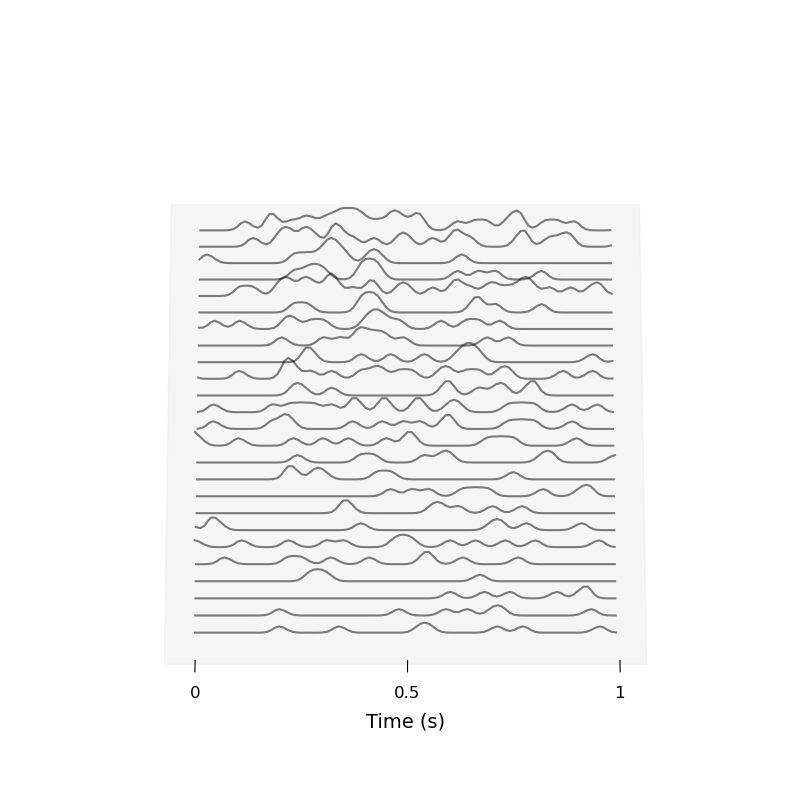

In [26]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

idx = 3
# sort by variancec
var = np.var(x_[idx], axis=0)
#order = np.argsort(np.max(x_[idx], axis=0))
#order = np.argsort(np.mean(x_[idx], axis=0))
order = np.argsort(var)[::-1]
ax.view_init(elev=75, azim=0)

# Transparent spines
ax.grid(False)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

for j, i in enumerate(order[0:25]):
    xx = x_[idx, :, i]
    # xx[xx <= -1] = np.nan
    ax.plot((2*j) * np.ones(x_.shape[1]), np.arange(x_.shape[1]), xx, 'k', alpha=0.5)
ax.set_zlim([0, 3])
ax.set_zticks([])
ax.set_xticks([])
#ax.set_xlabel('Neurons')
ax.set_yticks([0, 50, 100])
ax.set_yticklabels([0, 0.5, 1], fontsize=12)
#ax.tick_params(axis='y', labelize=14)
#ax.set_ylabel('Time (s)')
# fig, ax = lt.subplots(1, 1, figsize=(5, 5))
# ax.pcolor(x_[0].T, cmap='Greys')
ax.set_ylabel('Time (s)', fontsize=14, labelpad=10)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/M1_traces.pdf', bbox_inches='tight', pad_inhces=0)

/tmp/ipykernel_25900/2596312562.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_inhces" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/S1_traces.pdf', bbox_inches='tight', pad_inhces=0)


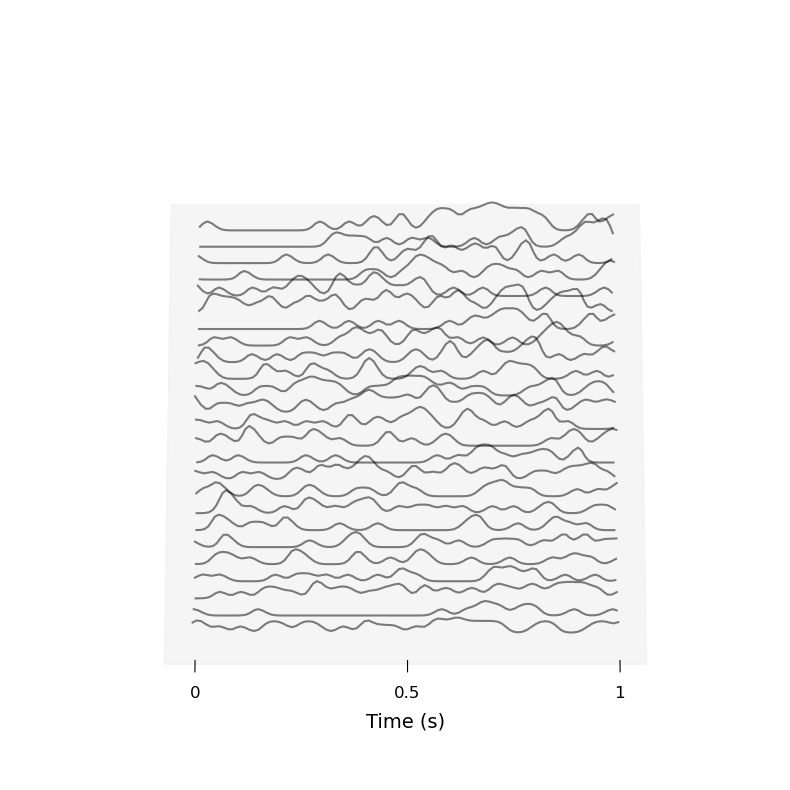

In [24]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

idx = 3
# sort by variancec
var = np.var(y_[idx], axis=0)
#order = np.argsort(np.max(x_[idx], axis=0))
#order = np.argsort(np.mean(x_[idx], axis=0))
order = np.argsort(var)[::-1]
ax.view_init(elev=75, azim=0)

# Transparent spines
ax.grid(False)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

for j, i in enumerate(order[0:25]):
    xx = y_[idx, :, i]
    # xx[xx <= -1] = np.nan
    ax.plot((2*j) * np.ones(y_.shape[1]), np.arange(y_.shape[1]), xx, 'k', alpha=0.5)
ax.set_zlim([0, 3])
ax.set_zticks([])
ax.set_xticks([])
#ax.set_xlabel('Neurons')
ax.set_yticks([0, 50, 100])
ax.set_yticklabels([0, 0.5, 1], fontsize=12)
#ax.tick_params(axis='y', labelize=14)
#ax.set_ylabel('Time (s)')
# fig, ax = lt.subplots(1, 1, figsize=(5, 5))
# ax.pcolor(x_[0].T, cmap='Greys')
ax.set_ylabel('Time (s)', fontsize=14, labelpad=10)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/S1_traces.pdf', bbox_inches='tight', pad_inhces=0)

In [ ]:
# Save as separate figures to be able to adjust spacing...